In [40]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from scipy.stats import ttest_ind
from collections import OrderedDict

from library.sb_utils import save_file

In [2]:
data = pd.read_csv('../data/cancer_data_cleaned.csv')

1. No categorical variables need classifying - all features numeric and continuous 
2. No complex distributions that need binning.
3. Some distributions could be log-normal? Possibly worth investigating, especially if I'm using hypothesis tests.
4. At this point, there doesn't seem to be any obvious reason to engineer or combine any features. In fact, one of the features, compactness, is itself an engineered feature. 

In [3]:
features = data.drop(columns = 'diagnosis')
features.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
#Descriptive statistics summary
features.describe().T

,count,mean,std,min,25%,50%,75%,max
radius_mean,569.0,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.11000
texture_mean,569.0,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.28000
perimeter_mean,569.0,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.50000
area_mean,569.0,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.00000
smoothness_mean,569.0,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.16340
compactness_mean,569.0,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.34540
concavity_mean,569.0,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.42680
concave points_mean,569.0,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.20120
symmetry_mean,569.0,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.30400
fractal_dimension_mean,569.0,0.062798,0.007060,0.049960,0.057700,0.061540,0.066120,0.09744


snakes: used to define and optimize bounadries of a cell nucleus

radius - averaging length of radial line sements defined by centroid of the snake and the individual snake points (pixels)

perimeter: total distance between the snake points (pixels)

area: count of number of pixels on interior of the snake and adding 1/2 of the pixels in the perimeter (pixels)

compactness: perimeter^2/area (dimensionless)

smoothness: difference between length of radial line and the mean length of the lines surrouding it (pixels)

concavity: size of small indents (pixels)

concave points: number of small contour concavities

symmetry: difference between the longest chord through the center and the perpendicular line to the cell boundary (both directions) (pixels)

fractal dimension:
1) perimeter of the nucleaus is measured using increasingly larger rulers
2) fractal dimension = negative slope of the log of perimeters measured this way

Higher value corresponds to less regular contour

texture: variance of the grayscale intensities in the component pixels


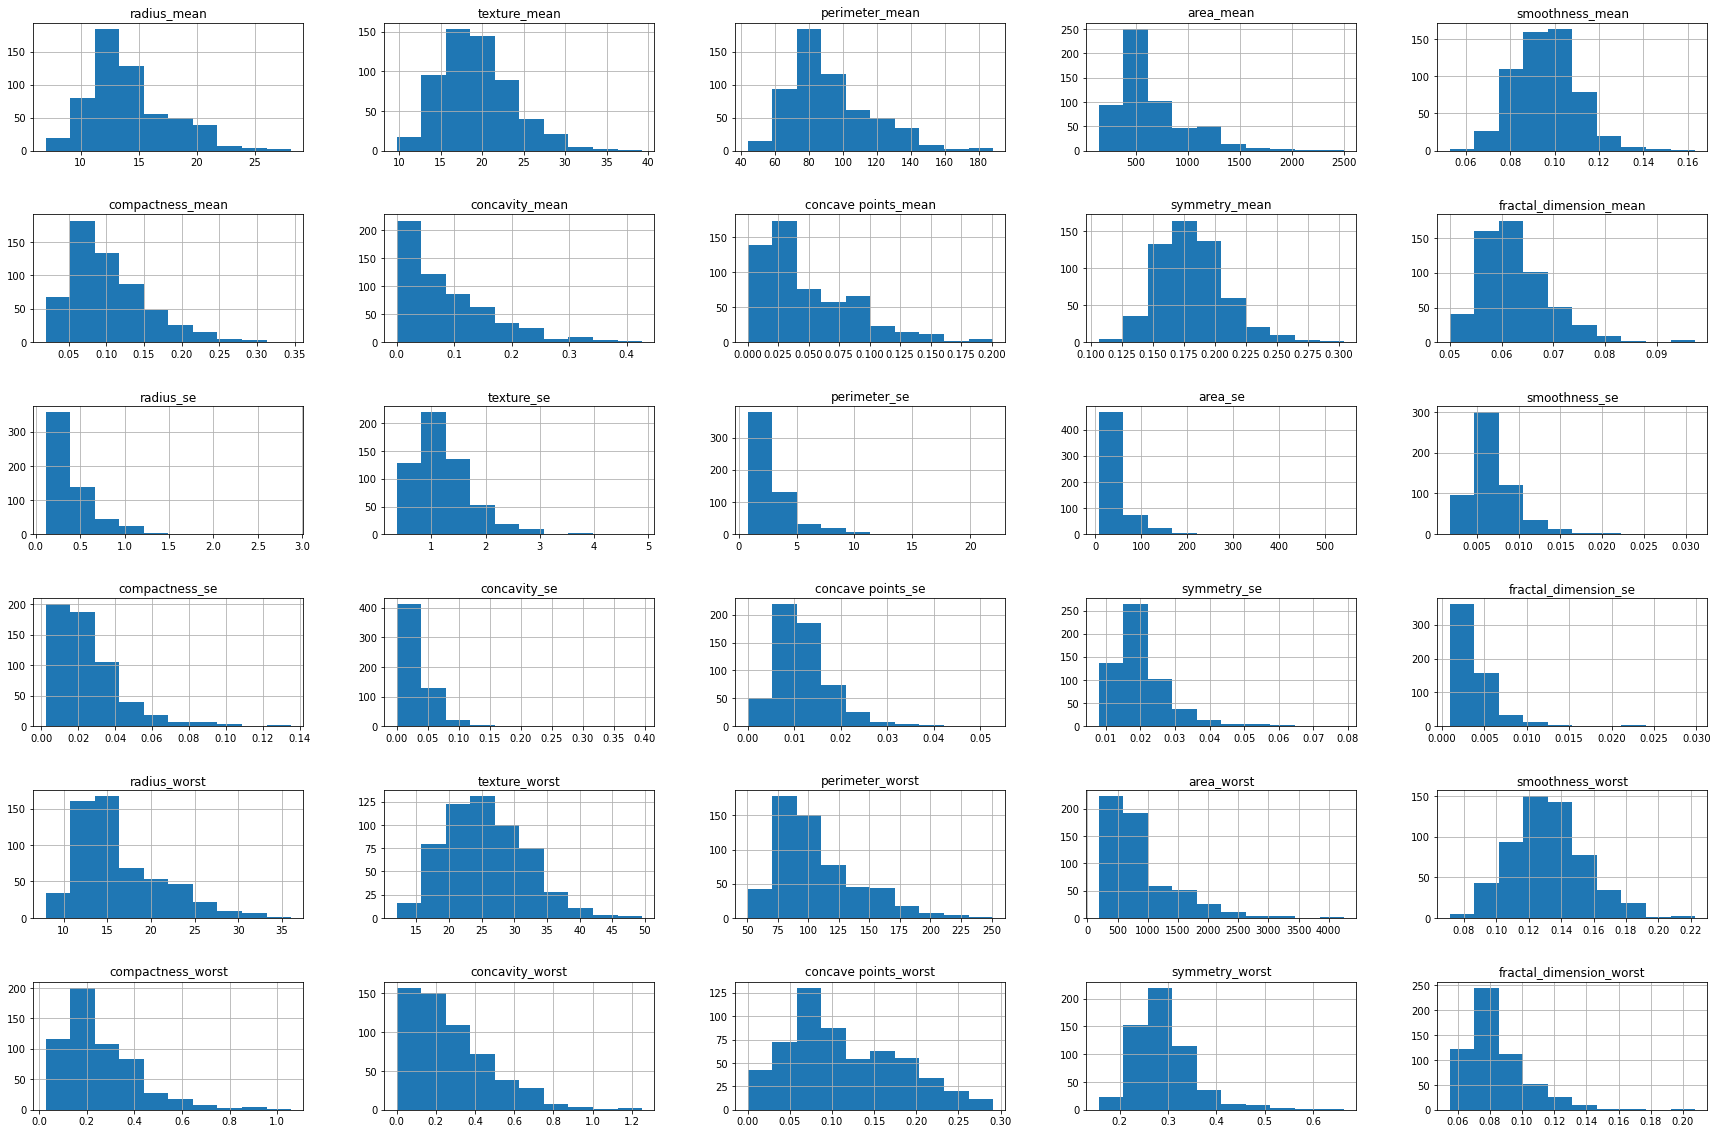

In [5]:
#Next, I want to check the distributions of each individual variable. 
#First, I'll repeat the histograms from the wrangling step
data.hist(figsize=(30,20))
plt.subplots_adjust(hspace=0.5);

'compactness_mean', 'concavity_mean', 'concave points_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'perimeter_worst', 'area_worst', 'compactness_worst', 'concavity_worst', 'fractal_dimension_worst'

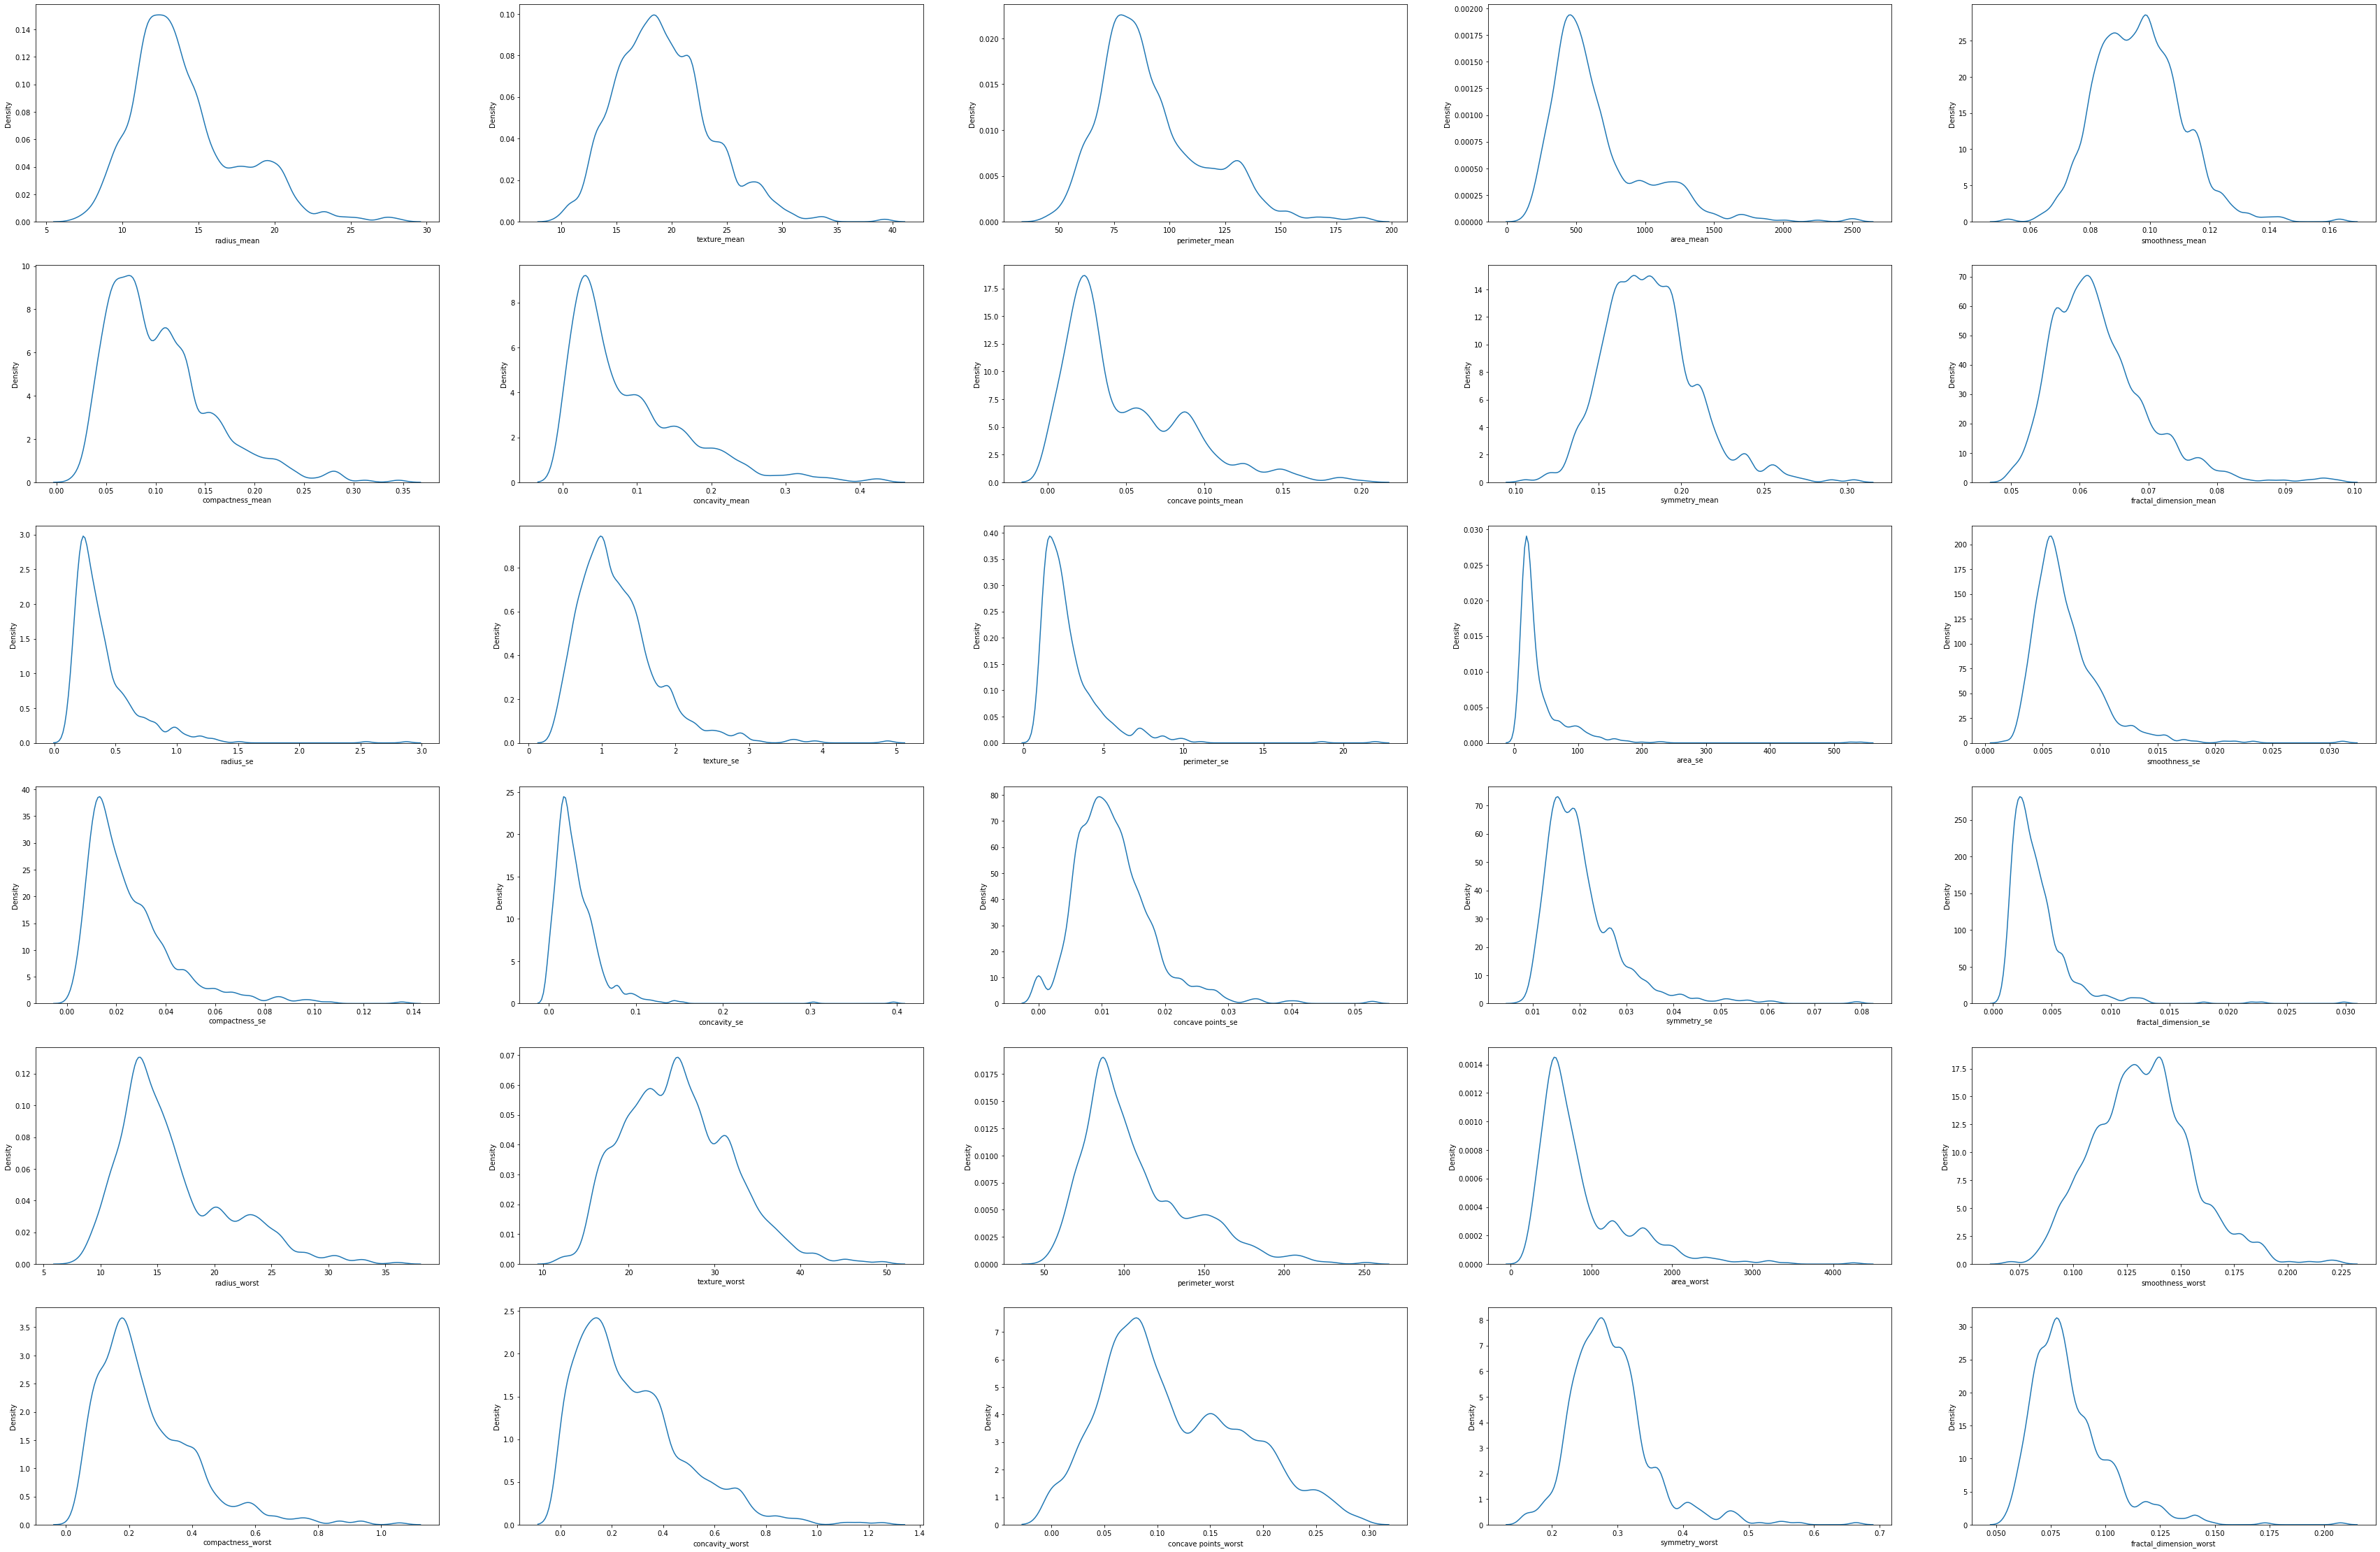

In [6]:
#Next, I'm going to experiment with the KDE plot
fig, ax = plt.subplots(6, 5, figsize=(60,40))
for i, axes in enumerate(ax.flat):        
    _ = sns.kdeplot(x=features.columns[i], data=features, ax = axes, bw_adjust=0.5)
plt.show()

In [7]:
#Lets test if some columns make more sense if we examine the distributions of their logs:

data_log = data.copy()




In [8]:
for col in data_log.columns:
    if col != 'diagnosis':
        data_log[col]  = np.log(data_log[col])

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Concave points is a bit interesting in terms of distribution. Also, several variables have rather long tails. Are these due to outliers, or are we observing the dichotomy between benign and malignant cells? 

Next step: compare distributions of 30 features between benign and malignant via violin plots

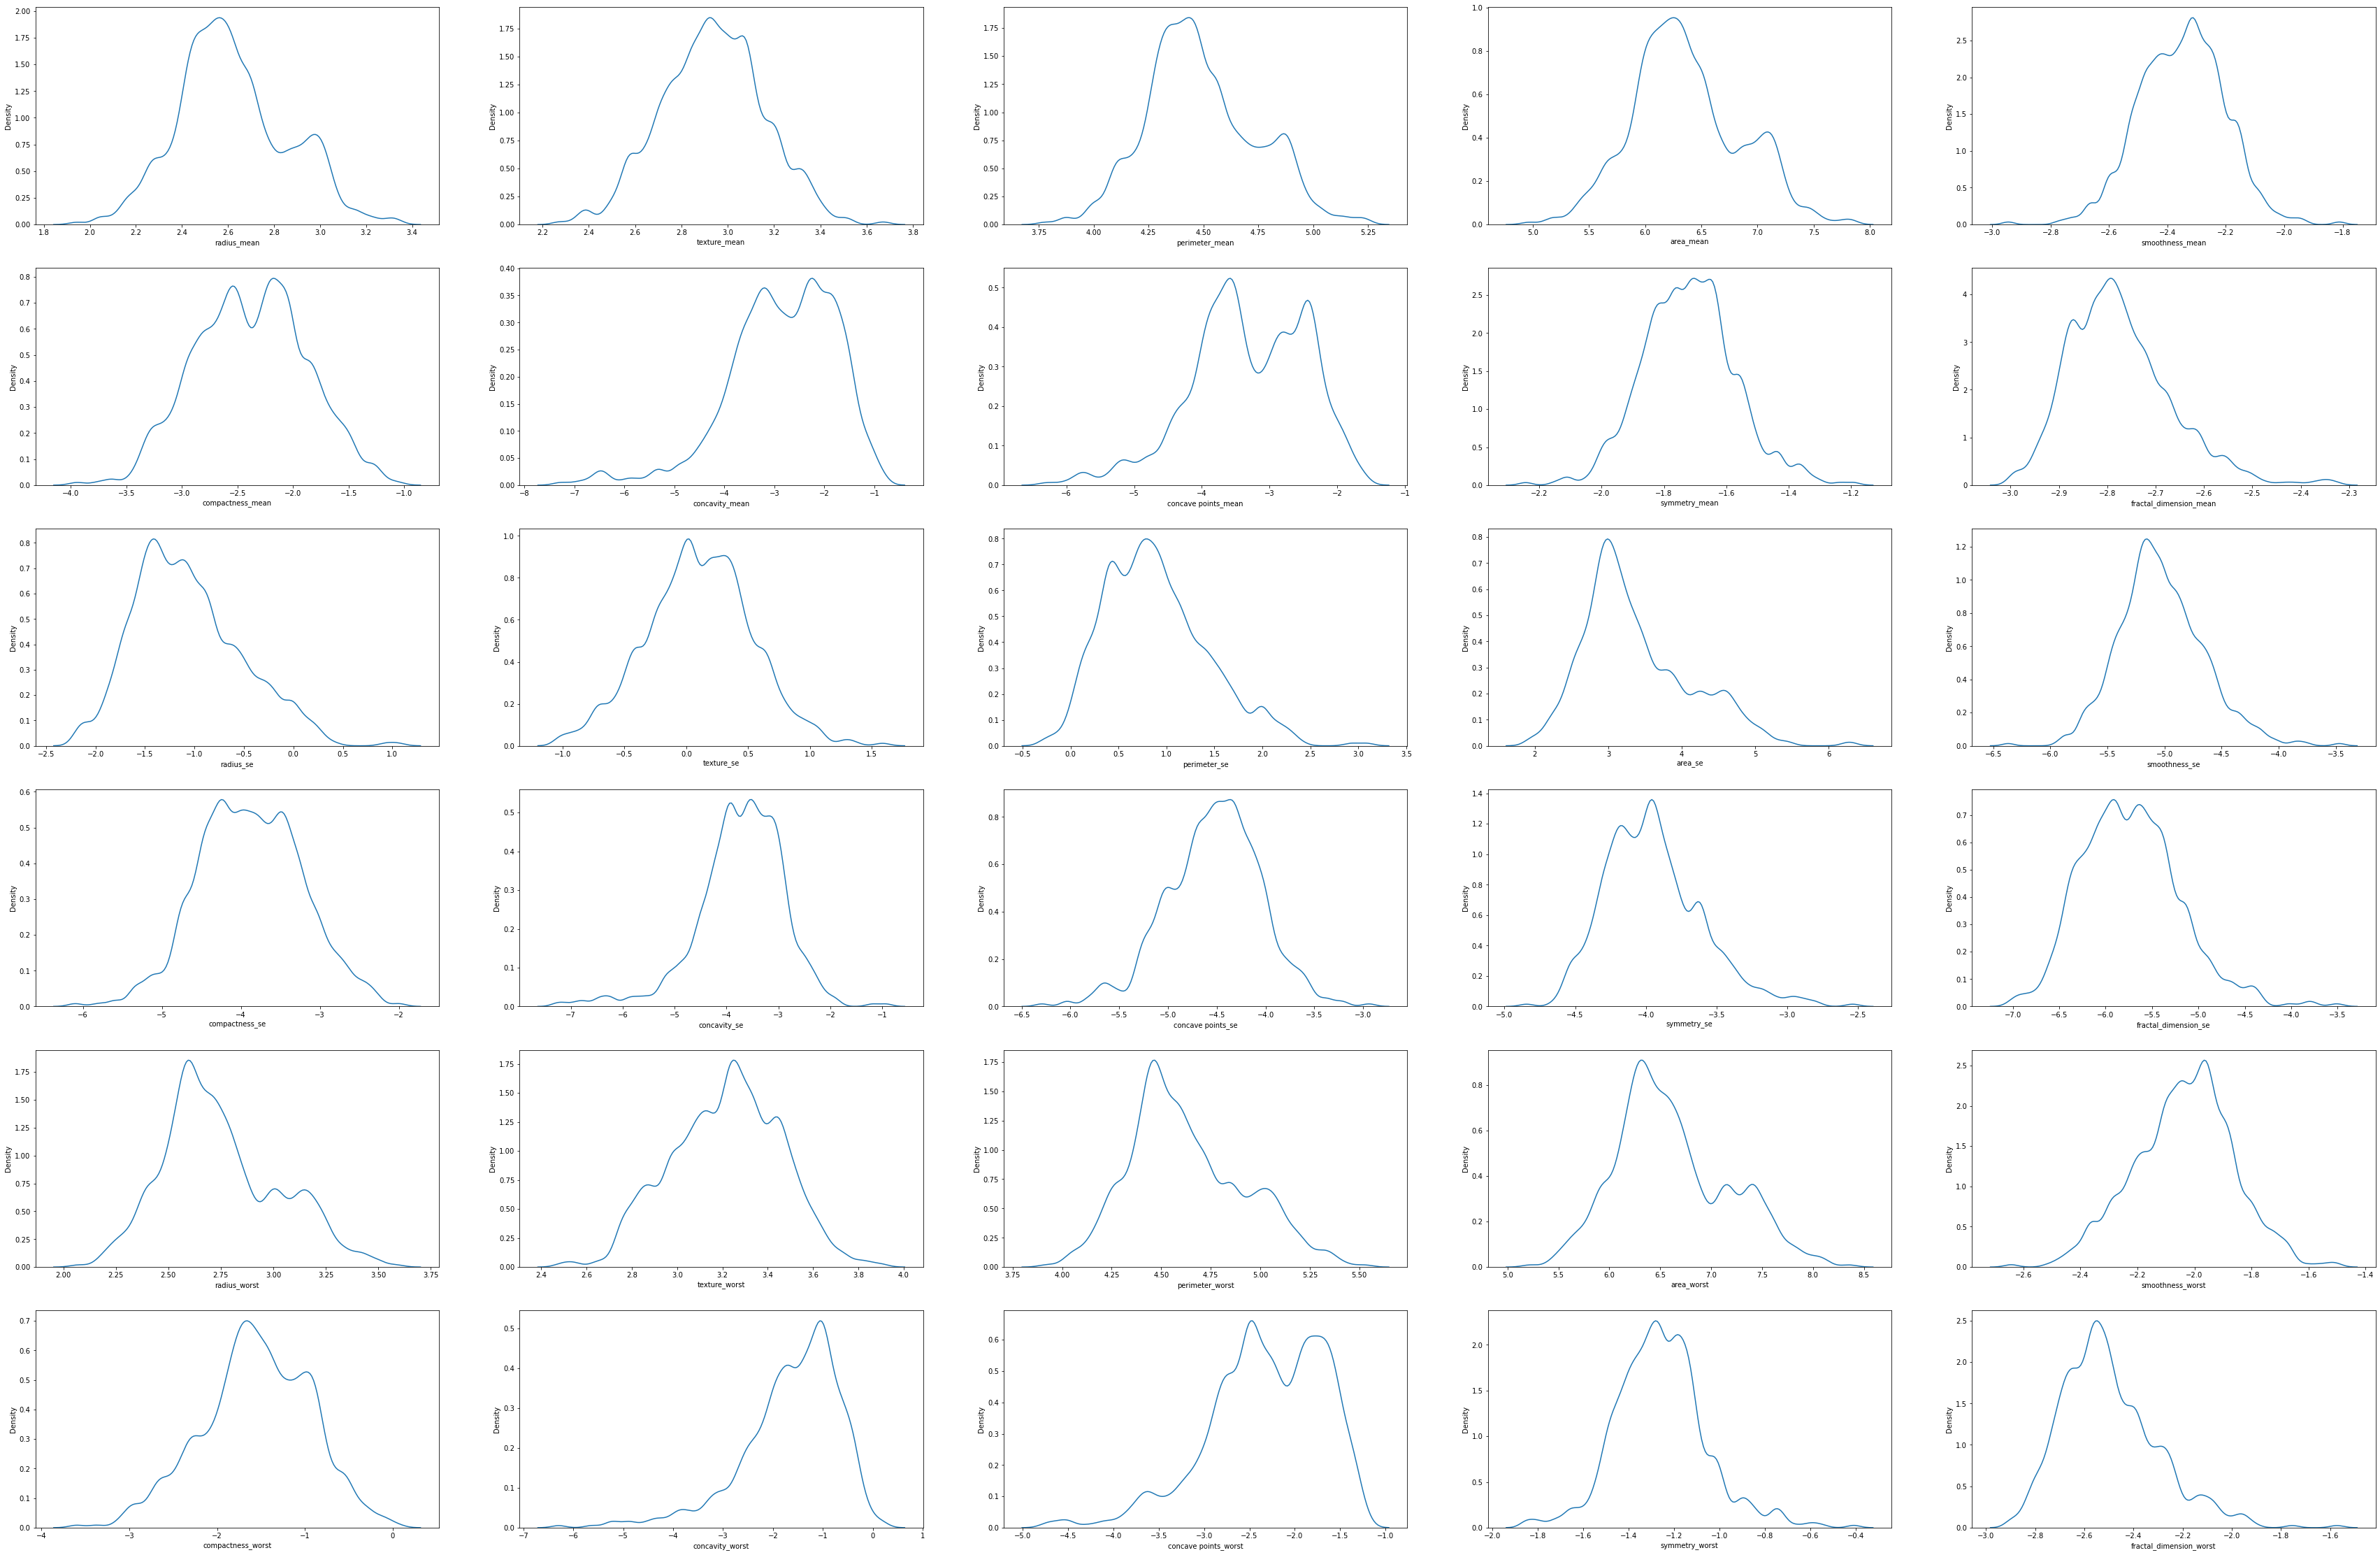

In [9]:
fig, ax = plt.subplots(6, 5, figsize=(60,40))
data_log_x = data_log.drop(columns='diagnosis')
for i, axes in enumerate(ax.flat):        
    _ = sns.kdeplot(x=data_log_x.columns[i], data=data_log_x, ax = axes, bw_adjust=0.5)
plt.show()

Several features might be made more usful if I look at their logs, will investigate further

In [10]:
#Split dataset into 3 groups of features: mean, se, and worst
features_std = (features-features.mean())/features.std()
mean = features_std.iloc[:, 0:10]
mean = pd.concat([data[['diagnosis']], mean], axis=1)
se = features_std.iloc[:, 10:20]
se = pd.concat([data[['diagnosis']], se], axis=1)
worst = features_std.iloc[:, 20:30]
worst = pd.concat([data[['diagnosis']], worst], axis=1)

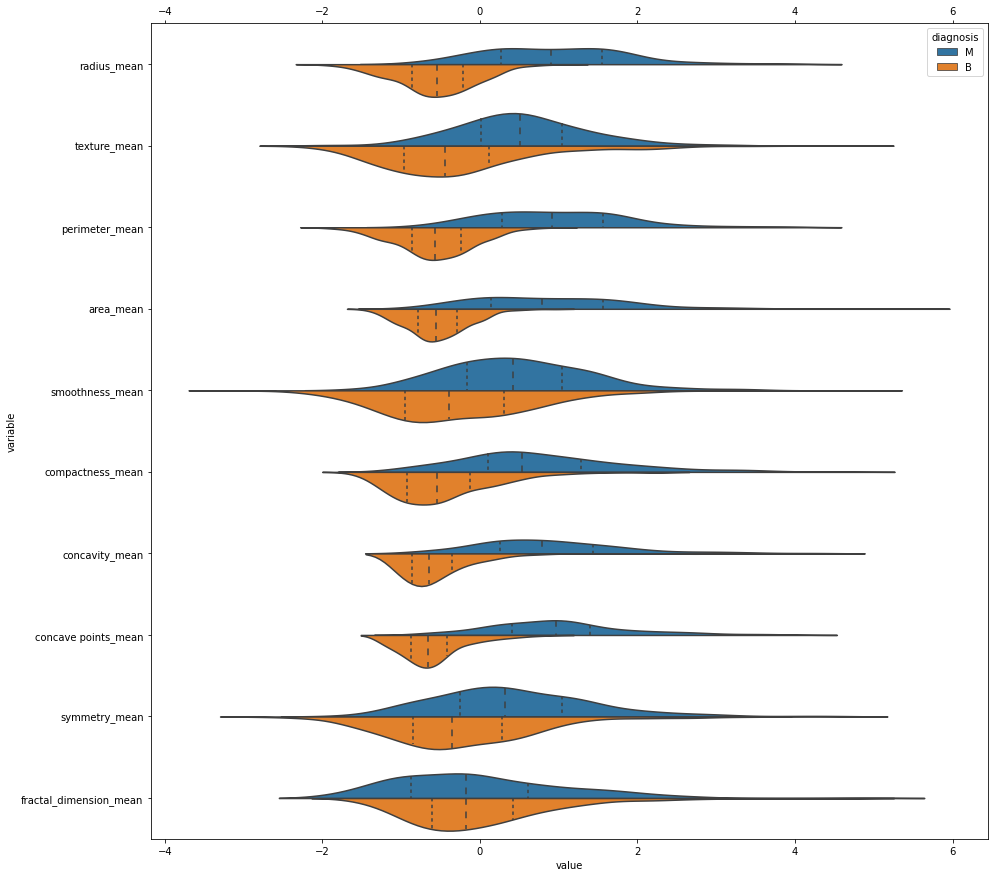

In [11]:
fig, ax = plt.subplots(figsize = (15,15))

mean_melt = mean.melt(id_vars="diagnosis")
_ = sns.violinplot(y='variable', x='value', data = mean_melt, hue='diagnosis', split=True, inner='quartile')
ax.tick_params(top=True)
ax.xaxis.set_tick_params(labeltop='on')

plt.show()

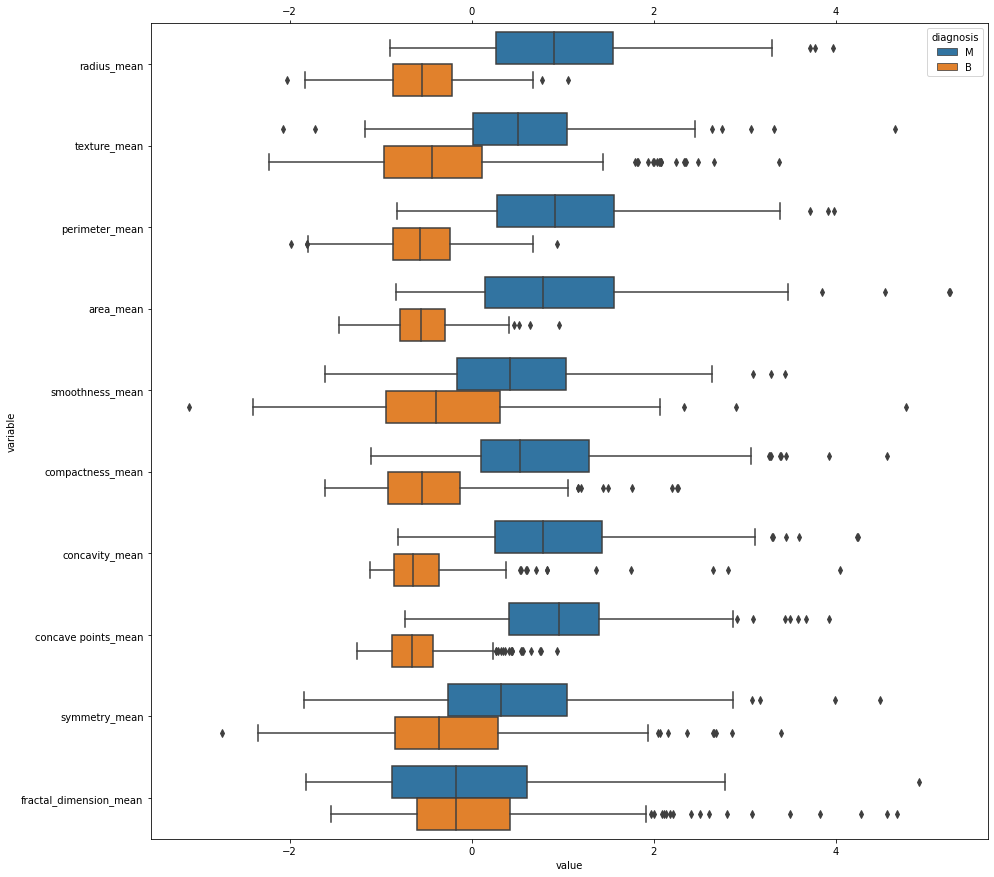

In [17]:
fig, ax = plt.subplots(figsize = (15,15))

_ = sns.boxplot(y='variable', x='value', data = mean_melt, hue='diagnosis')
ax.tick_params(top=True)
ax.xaxis.set_tick_params(labeltop='on')

plt.show()

Features with large differences between malignant and benign:

-radius_mean

-perimeter_mean

-area_mean

-compactness_mean*

-concavity_mean

Features with smaller differences between malignant and benign (possibly need testing)

-texture_mean

-smothness_mean

-concave points_mean

Features with almost no differences between malignant and benign (similar means, but different spreads):

-fractal_dimension_mean

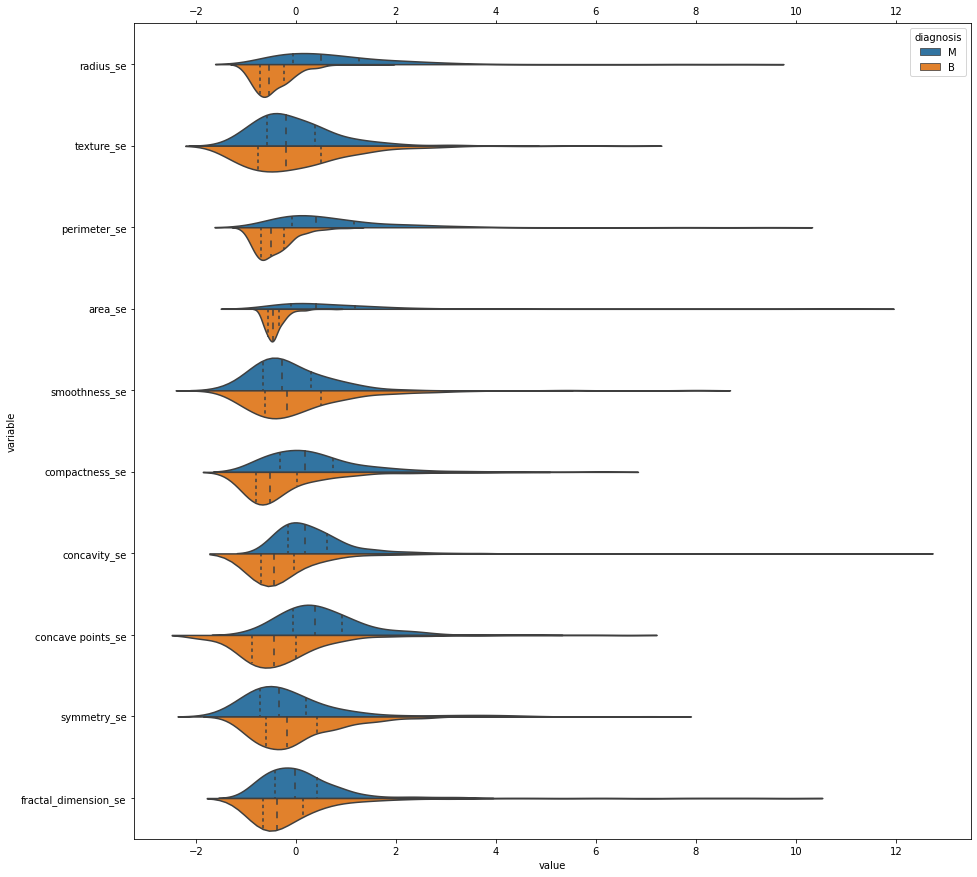

In [12]:
fig, ax = plt.subplots(figsize = (15,15))

se_melt = se.melt(id_vars="diagnosis")
_ = sns.violinplot(y='variable', x='value', data = se_melt, hue='diagnosis', split=True, inner='quartile')
ax.tick_params(top=True)
ax.xaxis.set_tick_params(labeltop='on')

plt.show()

Features with large differences between malignant and benign:

-radius_se

-perimeter_se

-area_se

Features with smaller differences between malignant and benign (possibly need testing)

-compactness_se*

-concavity_se

-concave points_se

-fractal_dimension_se

Features with almost no differences between malignant and benign (similar means, but different spreads):

-texture_se

-smoothness_se

-symmetry_se

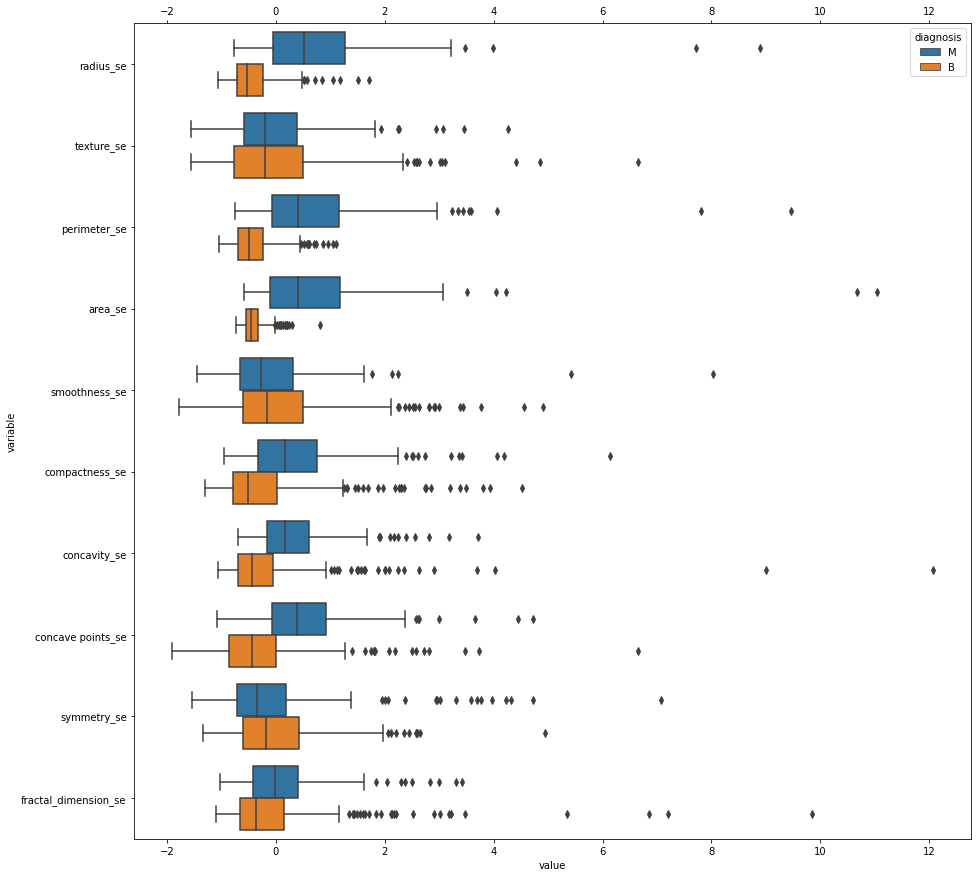

In [18]:
fig, ax = plt.subplots(figsize = (15,15))

_ = sns.boxplot(y='variable', x='value', data = se_melt, hue='diagnosis')
ax.tick_params(top=True)
ax.xaxis.set_tick_params(labeltop='on')

plt.show()

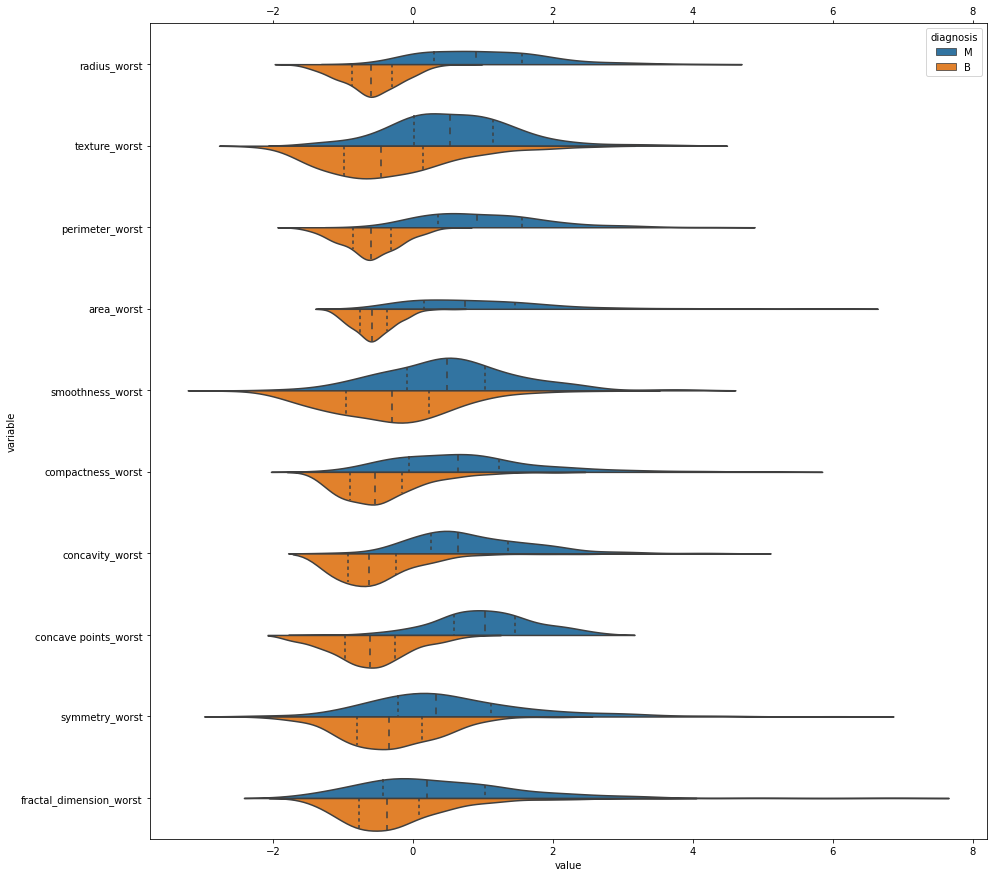

In [13]:
fig, ax = plt.subplots(figsize = (15,15))

worst_melt = worst.melt(id_vars="diagnosis")
_ = sns.violinplot(y='variable', x='value', data = worst_melt, hue='diagnosis', split=True, inner='quartile')
ax.tick_params(top=True)
ax.xaxis.set_tick_params(labeltop='on')

plt.show()

Features with large differences between malignant and benign:

-radius_worst

-perimeter_worst

-area_worst

-compactness_worst*

-concavity_worst

-concave poinst_worst

Features with smaller differences between malignant and benign:

-texture_worst

-smoothness_worst

-symmetry_worst

-fractal_dimension_worst

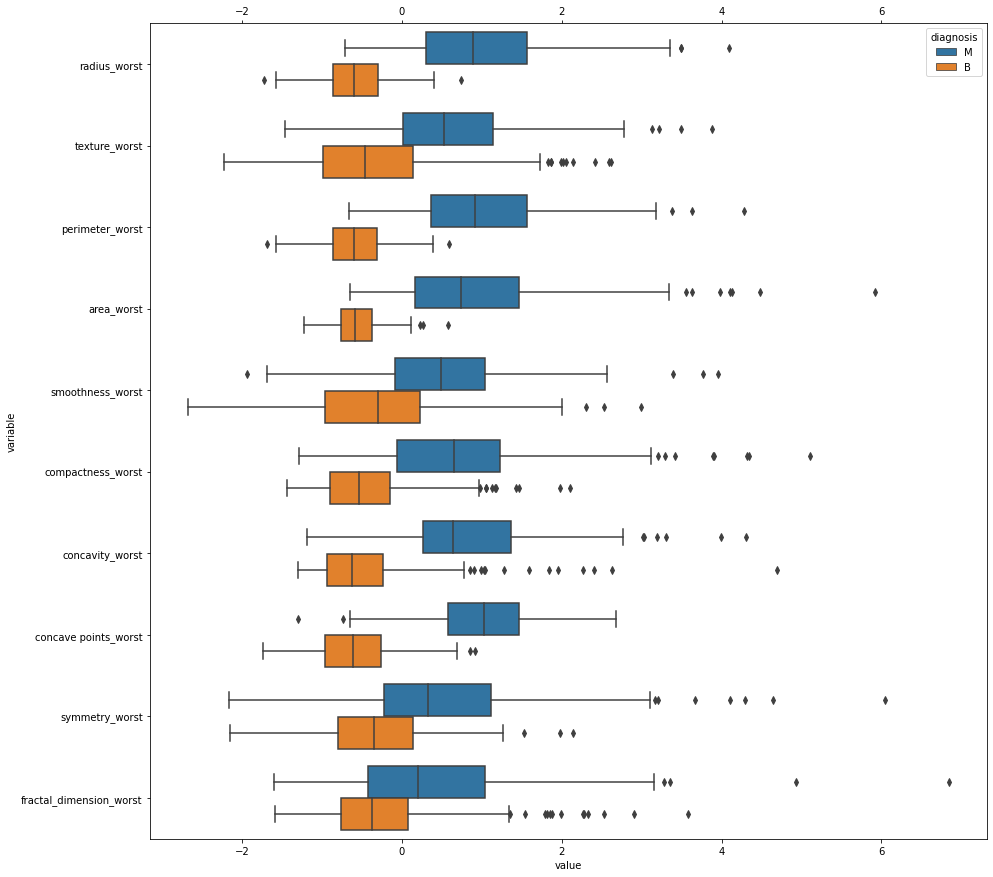

In [19]:
fig, ax = plt.subplots(figsize = (15,15))

_ = sns.boxplot(y='variable', x='value', data = worst_melt, hue='diagnosis')
ax.tick_params(top=True)
ax.xaxis.set_tick_params(labeltop='on')

plt.show()

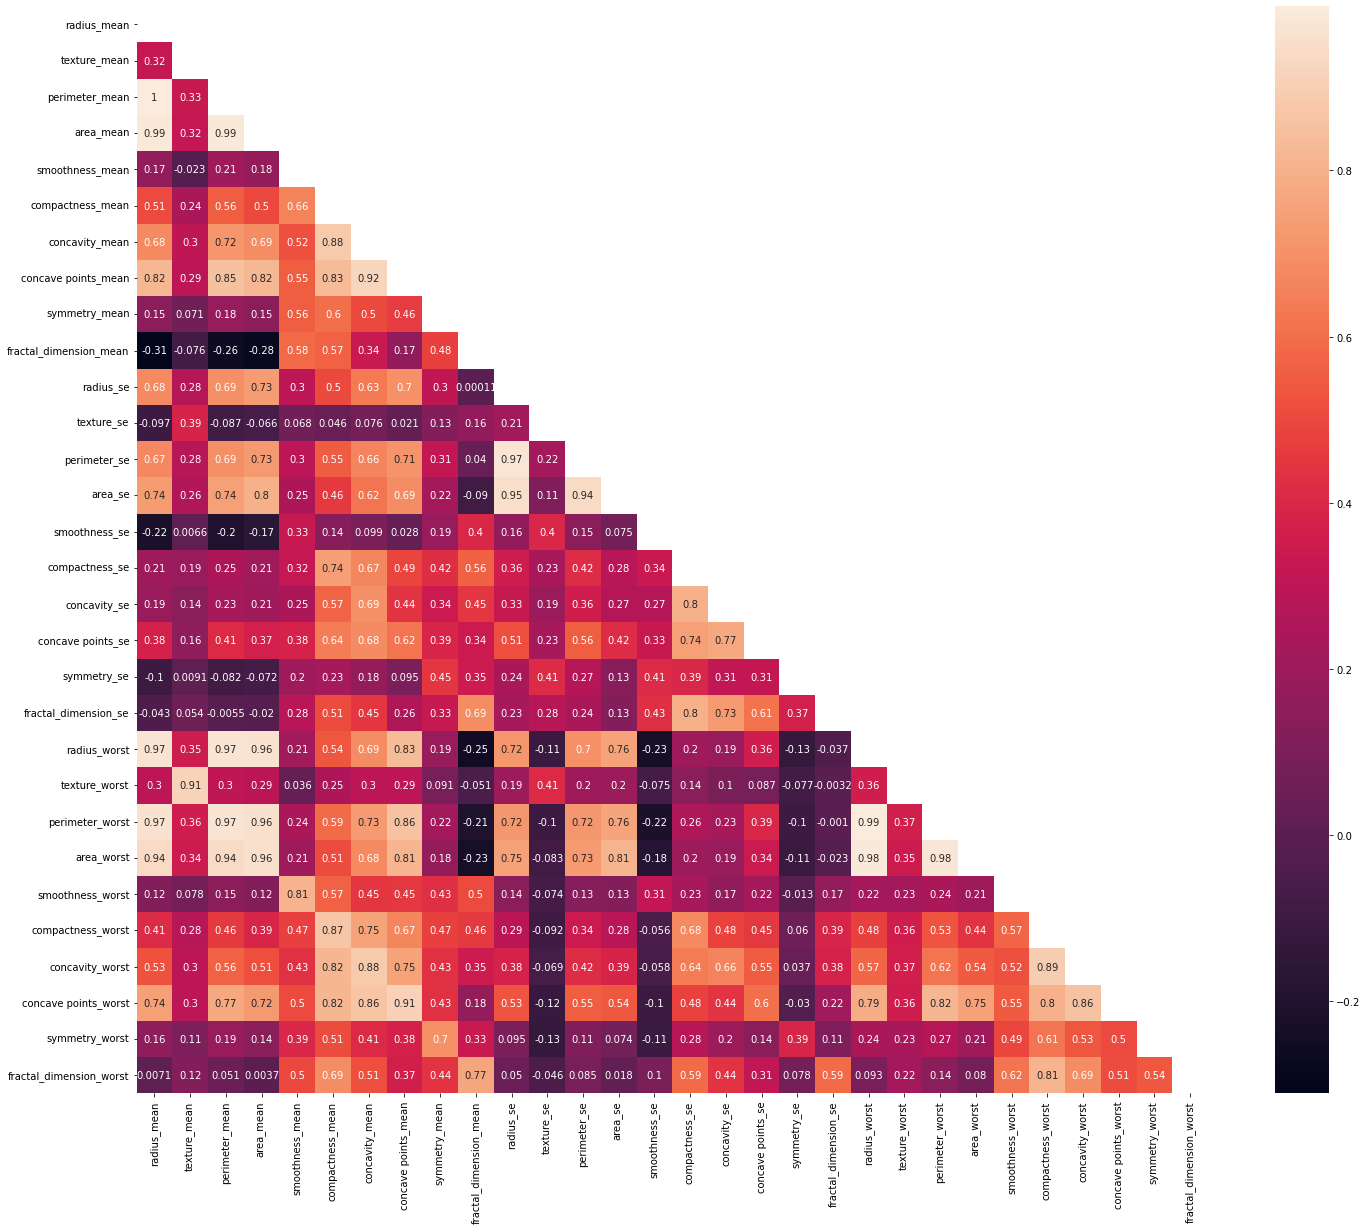

In [14]:
#Time to look at a heatmap

plt.subplots(figsize=(24,20))
# Compute the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

_ = sns.heatmap(corr, annot=True, mask=mask)
plt.show()

radius_mean is night-perfectly correlated with perimeter_mean, area_mean. It also has high correlation with mean concave points
Relatively strong correlation with standard error for radius, perimeter, and area
it has extremely high correlation with worst radius, area, and perimeter, and high correlation with worst concave points

texture mean and worst are also highly correlated


perimeter mean is extremely highly correlated with area mean, concave points_mean, concavity mean, and area_se (radius and perimeter se are up there too) as well as worst radius, perimeter, and area 
perimeter mean is also fairly highly correlated with worst concave points


concavity mean and concave points mean are extremely highly correlated

There is an absurd amount of multicollinearity in these features

In [53]:
test = {}
columns = data.columns[1:]
a = data[data['diagnosis']=='M']
b = data[data['diagnosis']=='B']
for i in columns:
    test[i] = ttest_ind(a[i], b[i], equal_var=False)

testdf = pd.DataFrame(test).T
testdf.columns = ['statistic', 'pvalue']

In [55]:
print(testdf.sort_values('pvalue'))

                         statistic        pvalue
concave points_worst     29.117659  1.061454e-96
perimeter_worst          25.332210  1.032730e-72
concave points_mean      24.844810  3.127316e-71
radius_worst             24.829745  3.556557e-71
perimeter_mean           22.935314  1.023141e-66
radius_mean              22.208798  1.684459e-64
concavity_worst          19.595726  9.852484e-59
concavity_mean           20.332425  3.742121e-58
area_worst               20.570814  4.937924e-54
area_mean                19.640990  3.284366e-52
compactness_mean         15.818246  9.607863e-42
compactness_worst        15.156872  1.749835e-38
radius_se                13.300706  1.491133e-30
texture_worst            12.264826  5.198708e-30
perimeter_se             12.832763  6.868553e-29
area_se                  12.155556  2.983568e-26
texture_mean             11.022087  3.019055e-25
smoothness_worst         10.819553  3.474376e-24
concave points_se        10.735452  4.042197e-24
smoothness_mean     

Nearly every feature has a clear difference between the means of benign and malignant samples. Fractal_dimension_se passes the conventional test for statistical significance at 0.042, but is comparatively borderline compared to the other useful features.

Smoothness_se, fractal_dimension_mean, texture_se, and symmetry_se do not appear to have statsitically distinct means between malignant and benign cells, and will likely not be used in our modeling.

In [ ]:
#Boxplots of Features of interest



In order to explore this dataset, I first used histograms and kde plots to examine the 30 numeric features of the dataset. While many appear to be approximately normal, several features (particularly the standard error features) have skewed distributions. The skewed features may be worth converting to their logs for further analysis.

Moreover, a number of features have biomodal distributions, indicating two distinct underlying distributions for malignant and benign tumors.

After standardizing these features, I generated both violin and boxplots of the features separated by diagnosis to visualize the underlying distributions and get a sense of which features had the most distinct divisions between malignant and benign diagnoses. 

Features that have the clearest separation between malignant and benign (i.e. no overlap in IQR):

-radius_mean

-perimeter_mean

-area_mean

-compactness_mean

-concavity_mean

-radius_se

-perimeter_se

-area_se

-radius_worst

-perimeter_worst

-area_worst

-compactness_worst

-concavity_worst

-concave poinst_worst

In order to confirm which features had statistically distinct means, I conducted hypothesis testing on the difference of means between malignant and benign distributions for each feature using Welch's T-Test. The Welch's T-Test was chosen due to the presence of unequal variances between the benign and malignant distributions. Nearly every feature has clearly distinct means, with p-values close to 0. One feature, fractal_dimension_se, has a statistically significant difference of means at a level of 0.05, but is borderline compared to most other features.

Smoothness_se, fractal_dimension_mean, texture_se, and symmetry_se do not appear to have statsitically distinct means between malignant and benign cells, and will likely not be used in our modeling.

Looking at a heatmap of the correlation matrix of the features reveals a severe amount of collinearity between features. Unsurprisingly, the features relating to radius, perimeter, and area are all almost perfectly correlated with one another, given their relationship. I am currently considering dropping several of these features.